<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

<div class="alert alert-info">This notebook is a copy of [Microsoft Recommender - Github repository](https://github.com/microsoft/recommenders/blob/main/examples/02_model_collaborative_filtering/als_deep_dive.ipynb) used for learning purposes. The contents of first section is unaltered and is rerun to generate results. The second section is extended with further experiments, learnings and analysis.</div>


# Spark Collaborative Filtering (ALS) Deep Dive

Spark MLlib provides a collaborative filtering algorithm that can be used for training a matrix factorization model, which predicts explicit or implicit ratings of users on items for recommendations.

This notebook presents a deep dive into the Spark collaborative filtering algorithm.

## Matrix factorization algorithm

### Matrix factorization for collaborative filtering problem

Matrix factorization is a common technique used in recommendation tasks. Basically, a matrix factorization algorithm tries to find latent factors that represent intrinsic user and item attributes in a lower dimension. That is,

$$\hat r_{u,i} = q_{i}^{T}p_{u}$$

where $\hat r_{u,i}$ is the predicted ratings for user $u$ and item $i$, and $q_{i}^{T}$ and $p_{u}$ are latent factors for item and user, respectively. The challenge to the matrix factorization problem is to find $q_{i}^{T}$ and $p_{u}$. This is achieved by methods such as matrix decomposition. A learning approach is therefore developed to converge the decomposition results close to the observed ratings as much as possible. Furthermore, to avoid overfitting issue, the learning process is regularized. For example, a basic form of such matrix factorization algorithm is represented as below.

$$\min\sum(r_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $\lambda$ is a the regularization parameter. 

In case explict ratings are not available, implicit ratings which are usually derived from users' historical interactions with the items (e.g., clicks, views, purchases, etc.). To account for such implicit ratings, the original matrix factorization algorithm can be formulated as 

$$\min\sum c_{u,i}(p_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $c_{u,i}=1+\alpha r_{u,i}$ and $p_{u,i}=1$ if $r_{u,i}>0$ and $p_{u,i}=0$ if $r_{u,i}=0$. $r_{u,i}$ is a numerical representation of users' preferences (e.g., number of clicks, etc.). 

### Alternating Least Square (ALS)

Owing to the term of $q_{i}^{T}p_{u}$ the loss function is non-convex. Gradient descent method can be applied but this will incur expensive computations. An Alternating Least Square (ALS) algorithm was therefore developed to overcome this issue. 

The basic idea of ALS is to learn one of $q$ and $p$ at a time for optimization while keeping the other as constant. This makes the objective at each iteration convex and solvable. The alternating between $q$ and $p$ stops when there is convergence to the optimal. It is worth noting that this iterative computation can be parallelised and/or distributed, which makes the algorithm desirable for use cases where the dataset is large and thus the user-item rating matrix is super sparse (as is typical in recommendation scenarios). A comprehensive discussion of ALS and its distributed computation can be found [here](http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf).

## Spark Mllib implementation

The matrix factorization algorithm is available as `ALS` module in [Spark `ml`](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) for DataFrame or [Spark `mllib`](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) for RDD. 

* The uniqueness of ALS implementation is that it distributes the matrix factorization model training by using "Alternating Least Square" method. 
* In the training method, there are parameters that can be selected to control the model performance.
* Both explicit and implicit ratings are supported by Spark ALS model.

## Spark ALS based MovieLens recommender

In the following code, the MovieLens-100K dataset is used to illustrate the ALS algorithm in Spark.

**Note**: This notebook requires a PySpark environment to run properly. Please follow the steps in [SETUP.md](https://github.com/Microsoft/Recommenders/blob/master/SETUP.md#dependencies-setup) to install the PySpark environment.

In [1]:
# set the environment path to find Recommenders
import sys
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import pandas as pd

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

from recommenders.datasets import movielens
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

System version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]
Pandas version: 1.4.1
PySpark version: 3.2.1


Data column names

In [2]:
MOVIELENS_DATA_SIZE = "100k"

COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

In [3]:
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

Model hyper parameters - these parameters are selected with reference to the benchmarking results [here](http://mymedialite.net/examples/datasets.html).

In [4]:
RANK = 10
MAX_ITER = 15
REG_PARAM = 0.05

Number of recommended items

In [5]:
K = 10

Initialize a Spark session.

In [6]:
spark = start_or_get_spark("ALS Deep Dive", memory="16g")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/14 22:52:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/14 22:52:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Load and prepare data

Data is read from csv into a Spark DataFrame.

In [7]:
dfs = movielens.load_spark_df(spark=spark, size=MOVIELENS_DATA_SIZE, schema=schema)

100%|█████████████████████████████████████| 4.81k/4.81k [00:00<00:00, 7.91kKB/s]


In [8]:
dfs.show(5)

+------+-------+------+---------+
|UserId|MovieId|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
+------+-------+------+---------+
only showing top 5 rows



Data is then randomly split by 80-20 ratio for training and testing.

In [9]:
dfs_train, dfs_test = spark_random_split(dfs, ratio=0.75, seed=42)

### Train a movielens model 

It is worth noting that Spark ALS model allows dropping cold users to favor a robust evaluation with the testing data. In case there are cold users, Spark ALS implementation allows users to drop cold users in order to make sure evaluations on the prediction results are sound.

In [10]:
als = ALS(
    maxIter=MAX_ITER, 
    rank=RANK,
    regParam=REG_PARAM, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop"
)

model = als.fit(dfs_train)

22/03/14 22:53:17 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/03/14 22:53:17 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/03/14 22:53:18 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


### Prediction with the model

The trained model can be used to predict ratings with a given test data.

In [11]:
dfs_pred = model.transform(dfs_test).drop(COL_RATING)

With the prediction results, the model performance can be evaluated.

In [12]:
evaluations = SparkRatingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)

/Users/chandrasingh/opt/anaconda3/envs/reco/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE score = 0.9672850377390322
MAE score = 0.7520024463135003
R2 score = 0.2606446451514729
Explained variance score = 0.265904981685646


Oftentimes ranking metrics are also of interest to data scientists. Note usually ranking metrics apply to the scenario of recommending a list of items. In our case, the recommended items should be different from those that have been rated by the users. 

In [15]:
# Get the cross join of all user-item pairs and score them.
users = dfs_train.select(COL_USER).distinct()
items = dfs_train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
dfs_pred = model.transform(user_item)

In [17]:
# Fix the ambiguous col exception
dfs1 = dfs_pred.alias("pred")
dfs2 = dfs_train.alias("train")

In [19]:
# Remove seen items.
# dfs_pred_exclude_train = dfs_pred.alias("pred").join(
#     dfs_train.alias("train"),
#     (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM] == dfs_train[COL_ITEM]),
#     how='outer'
# )
dfs_pred_exclude_train = dfs1.join(dfs2,
    (dfs1[COL_USER] == dfs2[COL_USER]) & (dfs1[COL_ITEM] == dfs2[COL_ITEM]),
    how='outer'
)

dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

dfs_pred_final.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|     46|  3.718766|
|     1|    255| 2.1994865|
|     1|    284| 2.9902596|
|     1|    285|  4.315481|
|     1|    318| 4.2022877|
|     1|    329|  3.364408|
|     1|    335|  2.745156|
|     1|    353| 3.8310368|
|     1|    371|  2.312728|
|     1|    372| 4.1308403|
|     1|    381| 3.6213713|
|     1|    391| 2.5517013|
|     1|    409|  2.576128|
|     1|    413| 2.8441556|
|     1|    417| 2.5588927|
|     1|    440| 0.5752399|
|     1|    449| 3.1248236|
|     1|    463|  4.198607|
|     1|    480|  4.484024|
|     1|    488| 4.0404654|
+------+-------+----------+
only showing top 20 rows



In [20]:
evaluations = SparkRankingEvaluation(
    dfs_test, 
    dfs_pred_final,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

/Users/chandrasingh/opt/anaconda3/envs/reco/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision@k = 0.043266171792152724
Recall@k = 0.01443145319982623
NDCG@k = 0.03709733077247258
Mean average precision = 0.0033258968835808275


### Fine tune the model

Prediction performance of a Spark ALS model is often affected by the parameters

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find the optimal combination of parameters. The following parameter set is used for training ALS models for comparison study purposes.

In [21]:
param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0]
}

Generate a dictionary for each parameter combination which can then be fed into model training.

In [22]:
param_grid = generate_param_grid(param_dict)

Train models with parameters specified in the parameter grid. Evaluate the model with, for example, the RMSE metric, and then record the metrics for visualization.

In [23]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=COL_USER, 
        itemCol=COL_ITEM, 
        ratingCol=COL_RATING, 
        coldStartStrategy="drop",
        **g
    )
    
    model = als.fit(dfs_train)
    
    dfs_pred = model.transform(dfs_test).drop(COL_RATING)
    
    evaluations = SparkRatingEvaluation(
        dfs_test, 
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 

/Users/chandrasingh/opt/anaconda3/envs/reco/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [24]:
rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

<AxesSubplot:xlabel='reg. parameter', ylabel='rank'>

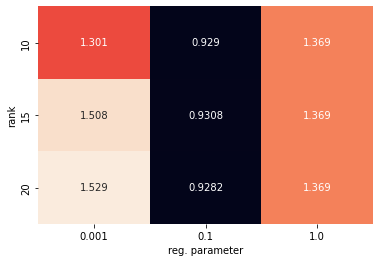

In [25]:
fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

The calculated RMSE scores can be visualized to comparatively study how model performance is affected by different parameters.

It can be seen from this visualization that RMSE first decreases and then increases as rank increases, due to overfitting. When the rank equals 20 and the regularization parameter equals 0.1, the model achieves the lowest RMSE score.

### Top K recommendation

#### Top k for all users (items)

In [26]:
dfs_rec = model.recommendForAllUsers(10)

In [27]:
dfs_rec.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|     1|[{1536, 3.891199}...|
|     3|[{1536, 3.1063848...|
|     6|[{1536, 3.7354305...|
|    12|[{1536, 4.4471893...|
|    13|[{1536, 3.3997421...|
|    16|[{1536, 4.5658073...|
|    20|[{1536, 3.3140035...|
|    22|[{1536, 3.7392457...|
|    26|[{1536, 3.1729913...|
|    27|[{1536, 3.4825768...|
+------+--------------------+
only showing top 10 rows



#### Top k for a selected set of users (items)

In [28]:
users = dfs_train.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, 10)

In [29]:
dfs_rec_subset.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|   471|[{1536, 3.3287532...|
|   463|[{1536, 3.1125836...|
|   148|[{1536, 3.9075735...|
+------+--------------------+



#### Run-time considerations for top-k recommendations

It is worth noting that usually computing the top-k recommendations for all users is the bottleneck of the whole pipeline (model training and scoring) of an ALS based recommendation system. This is because
* Getting the top k from all user-item pairs requires a cross join which is usually very computationally expensive. 
* Inner products of user-item pairs are calculated individually instead of leveraging matrix block multiplication features which are available in certain contemporary computing acceleration libraries (e.g., BLAS).

More details about possible optimizations of the top k recommendations in Spark can be found [here](https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html).

In [24]:
# cleanup spark instance
spark.stop()

## References

1. Yehuda Koren, Robert Bell, and Chris Volinsky, "Matrix Factorization Techniques for Recommender Systems
", ACM Computer, Vol. 42, Issue 8, pp 30-37, Aug., 2009.
2. Yifan Hu, Yehuda Koren, and Chris Volinsky, "Collaborative Filtering for Implicit Feedback Datasets
", Proc. IEEE ICDM, 2008, Dec, Pisa, Italy.
3. Apache Spark. url: https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
4. Seaborn. url: https://seaborn.pydata.org/
5. Scaling collaborative filtering with PySpark. url: https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html
6. Matrix Completion via Alternating Least Square (ALS). url: http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

# My Learnings

## Setup Environment
- Before starting to learn, following actions need to be taken on a local mac laptop 
  1. Create virtual environment for setting up kernel for interactive computing using Anaconda Jupyter and not pollute existing environment
  1. Setup ability to choose from multiple Java version
  1. Setup PySpark  
  1. Register environment variables with virtual environment and its associated ipykernel
  1. Setup git recommenders locally and build using the local git copy


- <div class="alert alert-warning"> Check the active sh - bash or zsh, accordingly update ~/.bash_profile or ~/.zshrc</div>  

> `$SHELL --version`  

zsh 5.8 (x86_64-apple-darwin21.0)  
- Renamed config.json to be able to switch to different venv without authentication hassle
> `cd ~/.jupyter/`  
> `mv jupyter_notebook_config.json jupyter_notebook_config.json.bkp`  
- Create new venv
> `python --version`
3.8.8  
> `conda create --name reco python=3.8.8`   
> `conda activate reco`  
- As a pre-requisite to installing the dependencies, if using Conda, make sure that Anaconda and the package manager Conda are both up to date
> `conda update conda -n root`  
> `conda install anaconda` since it is a new venv, otherwise `conda update anaconda`  
> `pip install pyspark`  

Successfully installed py4j-0.10.9.3 pyspark-3.2.1  
- [How to install java on mac](https://stackoverflow.com/questions/24342886/how-to-install-java-8-on-mac)  
> `brew tap adoptopenjdk/openjdk`  
> `brew install --cask adoptopenjdk8`  
- NOTE Spark requires Java version 8 or 11. We support Spark versions 3.0 and 3.1, but versions 2.4+ with Java version 8 may also work.
> `brew install --cask adoptopenjdk11`  
- If you want to install/manage multiple version then you can use 'jenv':  
> `echo 'export PATH="$HOME/.jenv/bin:$PATH"' >> ~/.bash_profile`  
> `echo 'eval "$(jenv init -)"' >> ~/.bash_profile`  
> `source ~/.bash_profile`  

- This will change the venv to base. Switch/Activate the environment  
> `jenv doctor`  
No JAVA_HOME set  
- Add the installed java to jenv  
> `jenv add /Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home`  
> `jenv add /Library/Java/JavaVirtualMachines/adoptopenjdk-11.jdk/Contents/Home`  
> `jenv versions`
- Configure the java version which you want to use:  
> `jenv global 11`  
> `jenv versions`  
- For v11
> `echo 'export JAVA_HOME=$(/usr/libexec/java_home -v11)' >> ~/.bash_profile` 
- or for v1.8
> `echo 'export JAVA_HOME=$(/usr/libexec/java_home -v1.8)' >> ~/.bash_profile` 
- If `jenv doctor` not set, use  
> `echo 'eval "$(jenv init -)"' >> ~/.zshrc`   
- Test `java --version` or `which java`
- Setup PySpark
> `RECO_ENV=$(conda env list | grep reco | awk '{print $NF}')`  
> `mkdir -p $RECO_ENV/etc/conda/activate.d`  
> `mkdir -p $RECO_ENV/etc/conda/deactivate.d`   
- Then, create the file \$RECO_ENV/etc/conda/activate.d/env_vars.sh and add:
```
#!/bin/sh
RECO_ENV=$(conda env list | grep reco | awk '{print $NF}')
export PYSPARK_PYTHON=$RECO_ENV/bin/python
export PYSPARK_DRIVER_PYTHON=$RECO_ENV/bin/python
unset SPARK_HOME
```
- This will export the variables every time we do `conda activate reco`. To unset these variables when we deactivate the environment, create the file $RECO_ENV/etc/conda/deactivate.d/env_vars.sh and add:
```
#!/bin/sh
unset PYSPARK_PYTHON
unset PYSPARK_DRIVER_PYTHON
```
- Register environment as kernel in Jupyter
> `python -m ipykernel install --name reco --display-name "Python (reco)"`
- Clone recommenders repo
> `git clone https://github.com/microsoft/recommenders`
- Change root directory of recommenders git folder where `setup.py` sits
- Install recommenders and additional package setups
> `pip install -e .`
- To roll back to older java version
> `jenv local 1.8`
- Reinstate JAVA_HOME environment and relaunch kernel


## ALS algorithm
### Why not SVD
### Sparsity 

## Spark internals

## Spark MLlib

## Hyperparameters

## Implementation packages

## Result analysis

## Improvements
### Explicit rating
### Implicit rating